In [69]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [70]:
df_raw = pd.read_csv('cl5.csv')

#### 1, 2, 3월 데이터만 추출

In [100]:
df = df_raw[~df_raw['REG_YYMM'].isin([201901,201902,201903])]
df.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
423,201904,제주,골프장 운영업,20s,1,1,3,403000,3,0
424,201904,제주,골프장 운영업,20s,2,1,3,53500,3,0
425,201904,제주,골프장 운영업,30s,1,2,385,57719564,557,0
426,201904,제주,골프장 운영업,30s,1,3,6,1022000,12,0
427,201904,제주,골프장 운영업,30s,2,2,160,21420725,218,0


In [39]:
df = df_raw
df.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
0,201901,제주,골프장 운영업,20s,2,1,10,905400,12,0
1,201901,제주,골프장 운영업,30s,1,2,214,27806852,275,0
2,201901,제주,골프장 운영업,30s,2,2,101,9855353,150,0
3,201901,제주,골프장 운영업,40s,1,2,137,18086875,178,0
4,201901,제주,골프장 운영업,40s,1,3,855,121834201,1088,0


# Data Preprocessing

In [101]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [102]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [103]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [104]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [105]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month,Season
423,제주,골프장 운영업,20s,1,1,3,403000,3,0,2019,4,Spring
424,제주,골프장 운영업,20s,2,1,3,53500,3,0,2019,4,Spring
425,제주,골프장 운영업,30s,1,2,385,57719564,557,0,2019,4,Spring
426,제주,골프장 운영업,30s,1,3,6,1022000,12,0,2019,4,Spring
427,제주,골프장 운영업,30s,2,2,160,21420725,218,0,2019,4,Spring


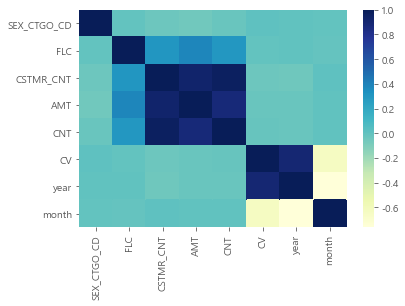

In [106]:
sns.heatmap(df.corr(),cmap='YlGnBu',fmt='.1g')

# Label Encoding

In [107]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1812 entries, 423 to 2234
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CARD_SIDO_NM  1812 non-null   int32
 1   STD_CLSS_NM   1812 non-null   int32
 2   AGE           1812 non-null   int32
 3   SEX_CTGO_CD   1812 non-null   int64
 4   FLC           1812 non-null   int64
 5   CSTMR_CNT     1812 non-null   int64
 6   AMT           1812 non-null   int64
 7   CNT           1812 non-null   int64
 8   CV            1812 non-null   int64
 9   year          1812 non-null   int64
 10  month         1812 non-null   int64
 11  Season        1812 non-null   int32
dtypes: int32(4), int64(8)
memory usage: 155.7 KB


In [109]:
df.STD_CLSS_NM.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [110]:
df['month'].unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3], dtype=int64)

# Preprocessing

In [111]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('AMT')

In [112]:
X = df.drop(['AMT'], axis=1)
y = np.log1p(df['AMT'])

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [114]:
X_train

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,CNT,CV,year,month,Season
518,0,6,1,1,1,581,717,0,2019,4,1
1343,0,1,6,1,5,717,1754,0,2019,10,0
1995,0,3,4,2,4,4985,11383,2,2020,2,3
816,0,6,2,2,2,1390,1720,0,2019,6,2
905,0,3,1,1,1,974,1647,0,2019,7,2
...,...,...,...,...,...,...,...,...,...,...,...
473,0,3,1,2,2,177,278,0,2019,4,1
1101,0,5,3,1,4,4,6,0,2019,8,2
1777,0,0,3,1,3,933,1198,1,2020,1,3
1687,0,3,5,1,5,3835,9311,0,2019,12,3


# Light Gradient Boosting Machine

In [115]:
import lightgbm as lgb

In [116]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [117]:
params = {
            'learning_rate' : 0.1,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1        }

In [118]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.27578
[200]	valid_0's rmse: 0.269924
[300]	valid_0's rmse: 0.270664
Early stopping, best iteration is:
[251]	valid_0's rmse: 0.269127


# Template

In [119]:
X.columns

Index(['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT',
       'CNT', 'CV', 'year', 'month', 'Season'],
      dtype='object')

In [120]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [121]:
temp

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,year,month,Season
0,0,0,1,1,1,2020,4,1
1,0,0,1,1,1,2020,4,2
2,0,0,1,1,1,2020,4,0
3,0,0,1,1,1,2020,4,3
4,0,0,1,1,1,2020,7,1
...,...,...,...,...,...,...,...,...
5035,0,8,0,2,5,2020,4,3
5036,0,8,0,2,5,2020,7,1
5037,0,8,0,2,5,2020,7,2
5038,0,8,0,2,5,2020,7,0


In [122]:
df2 = df[(df['year']==2020) & (df['month']==3)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

In [123]:
df4.drop(['AMT', 'year', 'month', 'Season'], axis=1, inplace=True)

In [124]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC'])

In [125]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [126]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [127]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [128]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감률'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감률
0,골프장 운영업,1.154520e+09,1227910031,-5.976829
1,그외 기타 종합 소매업,1.342262e+09,3282513600,-59.108706
2,기타 수상오락 서비스업,2.926529e+08,1606700,18114.535134
3,기타음식료품위주종합소매업,9.059178e+08,3616119943,-74.947794
4,내항 여객 운송업,5.683999e+08,66432400,755.606493
5,마사지업,2.636809e+08,2660000,9812.817068
6,스포츠 및 레크레이션 용품 임대업,2.622396e+09,1752880768,49.604913
7,육류 소매업,8.894118e+08,1000851231,-11.134466
8,택시 운송업,7.169766e+07,471100,15119.202293


In [129]:
temp.to_csv('./template5.csv',index=False, encoding='utf-8-sig')